## Filtering Observed Arrivals
As the [API Exploration Notebook](API_exploration.ipynb) shows, each poll of the scraper produces 3 predicted arrival times for each line direction at a station. We want to transform and reduce these data to only feature observed train arrivals at stations ([per this issue](https://github.com/CivicTechTO/ttc_subway_times/issues/13)).

This notebook explores how to do this. 

In [20]:
import datetime
from psycopg2 import connect
import configparser
import pandas as pd
import pandas.io.sql as pandasql
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import matplotlib.ticker as ticker

In [2]:
CONFIG = configparser.ConfigParser(interpolation=None)
CONFIG.read('../db.cfg')
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)

## Goal
We want to generate observed arrival times, in a format similar to [GTFS](https://github.com/google/transit/blob/master/gtfs/spec/en/reference.md#stop_timestxt). The GTFS schedule will be useful in this process, data was downloaded from [Transit Feeds](https://transitfeeds.com/p/ttc/33), the schema of the data is in [ttc_gtfs_create.sql](../ttc_gtfs_create.sql) and it is processed to a more useful format in PostgreSQL with [ttc_gtfs_process.sql](../ttc_gtfs_process.sql).

From gtfs, we can get a sense of the target data count, how many stops are scheduled on the three subway lines for which we have data?

In [8]:
sql = '''SELECT COUNT(1)

FROM gtfs.stop_times 
INNER JOIN gtfs.trips USING (trip_id)
INNER JOIN gtfs.routes USING (route_id)
INNER JOIN gtfs.calendar USING (service_id)
WHERE monday AND route_type = 1 AND route_short_name != '3'
'''

with con.cursor() as cur:
    cur.execute(sql)
    print(cur.fetchone()[0])

46404


This is a ball park figure we are aiming for in our filtering. 
Creating a materialized view of the raw poll data for a given day Wednesday, June 14th 2017 

In [9]:
sql = '''DROP MATERIALIZED VIEW IF EXISTS test_day CASCADE; 
CREATE MATERIALIZED VIEW test_day AS 
SELECT requestid, stationid, lineid, create_date, request_date, station_char, subwayline, system_message_type, 
            timint, traindirection, trainid, train_message
FROM requests
INNER JOIN ntas_data USING (requestid)
WHERE request_date >= '2017-06-14'::DATE + interval '5 hours' 
AND request_date <  '2017-06-14'::DATE + interval '29 hours' 
''' 
with con:
    with con.cursor() as cur:
        cur.execute(sql)

In [10]:
with con.cursor() as cur:
    cur.execute('SELECT COUNT(1) FROM test_day')
    print(cur.fetchone()[0])

554390


Cool. Definitely some work to do.


Trying out a very basic filter, which has a [Known Issue](https://github.com/CivicTechTO/ttc_subway_times/issues/13#issuecomment-286609328)

In [22]:
sql = '''SELECT COUNT(DISTINCT (requestid, lineid, trainid, traindirection, stationid))
FROM test_day 
WHERE train_message = 'AtStation' OR timint < 1'''

with con.cursor() as cur:
    cur.execute(sql)
    print(cur.fetchone()[0])

81483


It's a start. 

If every line takes more than an hour to do a round-trip, we might be able to look for a distinct train-line-direction-station combination for each hour.

In [11]:
sql = '''WITH trips AS (SELECT route_short_name, (SELECT trip_id FROM gtfs.trips WHERE trips.route_id = routes.route_id LIMIT 1) 
FROM gtfs.routes
WHERE route_type = 1 AND route_short_name != '3' )

SELECT route_short_name, MIN(arrival_time) AS "Start Time", MIN(stop_sequence) ||'-'||MAX(stop_sequence) AS "Stops", MAX(arrival_time) - MIN(arrival_time) AS "Half-trip time"
FROM gtfs.stop_times
INNER JOIN trips USING(trip_id)
GROUP BY route_short_name, trip_id
ORDER BY route_short_name, trip_id
'''

trips = pandasql.read_sql(sql, con)

In [12]:
trips

,route_short_name,Start Time,Stops,Half-trip time
0,1,05:37:49,1-32,00:57:45
1,2,05:40:30,1-31,00:51:27
2,4,05:30:15,1-2,00:02:39


So any given train on line 1 or 2 shouldn't pass the same station going the same direction in an hour. So we could add the hour in a `DISTINCT` query.

What's up with Line 4? It's short, but not two stations short... According to [TransitFeeds](https://transitfeeds.com/p/ttc/33/latest/trip/34859462), a GTFS host and exploration platform, Line 4 trains start the day at non-terminus stations. Line 4 actually makes 5 stops, and it takes 8 minutes to go from one terminus to another, with a two and a half minute layover at each terminus. 

Potential issues:
 - headways varying throughout the day
 - delays can push a unique train stop arrival at a station into multiple time boxes. 
 
Better solution:
 - look at each train chronologically through the day and
   * identify when there are multiple observations in a same trip at a same station
   * identify when the train changes direction

In [19]:
sql = ''' WITH unique_trains AS 
    (SELECT lineid::TEXT, COUNT(DISTINCT trainid) AS "Number of trains in a day"
     FROM test_day
     GROUP BY lineid)
     , unique_trips AS(SELECT route_short_name AS lineid, COUNT(DISTINCT trip_id) AS "Number of scheduled trips"
            FROM gtfs.routes -- ON lineid::TEXT = route_short_name
            INNER JOIN gtfs.trips USING (route_id)
            INNER JOIN gtfs.calendar USING (service_id)
            WHERE monday AND route_type = 1 AND route_short_name != '3'
            GROUP BY route_short_name)
            
    SELECT *
        FROM unique_trains
        INNER JOIN unique_trips USING (lineid)
        ORDER BY lineid'''
pandasql.read_sql(sql, con)

,lineid,Number of trains in a day,Number of scheduled trips
0,1,163,738
1,2,157,700
2,4,72,457


In [4]:
sql = ''' SELECT trainid, lineid, traindirection, stationid, station_char, create_date, request_date, timint, train_message
        FROM test_day
        INNER JOIN (SELECT trainid FROM test_day WHERE lineid = 1 AND create_date::TIME > '07:00'::TIME LIMIT 1) one_train USING (trainid)
        WHERE (timint < 1 OR train_message != 'Arriving') AND lineid = 1
        ORDER BY create_date
'''
one_train = pandasql.read_sql(sql, con)

In [5]:
one_train

,trainid,lineid,traindirection,stationid,station_char,create_date,request_date,timint,train_message
0,141,1,South,30,SHP2,2017-06-14 05:50:06,2017-06-14 05:50:01.529971,0.000000,AtStation
1,141,1,South,29,YKM2,2017-06-14 05:52:06,2017-06-14 05:52:01.566292,0.896471,Arriving
2,141,1,South,29,YKM2,2017-06-14 05:53:07,2017-06-14 05:53:02.486092,0.000000,AtStation
3,141,1,South,28,LAW2,2017-06-14 05:55:05,2017-06-14 05:55:01.532195,0.812800,Arriving
4,141,1,South,27,EGL2,2017-06-14 05:59:06,2017-06-14 05:59:02.506222,0.274918,Arriving
5,141,1,South,27,EGL2,2017-06-14 06:00:06,2017-06-14 06:00:02.395306,0.000000,AtStation
6,141,1,South,27,EGL2,2017-06-14 06:01:06,2017-06-14 06:01:02.224179,0.000000,AtStation
7,141,1,South,11,MUS2,2017-06-14 06:02:06,2017-06-14 06:02:02.127224,18.099605,Delayed
8,141,1,South,12,QPK2,2017-06-14 06:02:06,2017-06-14 06:02:02.127553,16.777805,Delayed
9,141,1,South,13,STP2,2017-06-14 06:02:06,2017-06-14 06:02:02.127905,15.583304,Delayed


## Using the filtered schema instead

In [7]:
sql = '''CREATE MATERIALIZED VIEW filtered.test_day AS 
SELECT requestid, stationid, lineid, create_date, request_date, station_char, subwayline, system_message_type, 
            timint, traindirection, trainid, train_message
FROM filtered.requests
INNER JOIN filtered.ntas_data USING (requestid)
WHERE request_date >= '2017-06-14'::DATE + interval '5 hours' 
AND request_date <  '2017-06-14'::DATE + interval '29 hours' 
''' 
with con:
    with con.cursor() as cur:
        cur.execute(sql)

In [8]:
sql = ''' SELECT trainid, lineid, traindirection, stationid, station_char, create_date, request_date, timint, train_message
        FROM filtered.test_day
        INNER JOIN (SELECT trainid FROM filtered.test_day WHERE lineid = 1 AND create_date::TIME > '07:00'::TIME LIMIT 1) one_train USING (trainid)
        WHERE (timint < 1 OR train_message != 'Arriving') AND lineid = 1
        ORDER BY create_date
'''
one_train = pandasql.read_sql(sql, con)

In [9]:
one_train

,trainid,lineid,traindirection,stationid,station_char,create_date,request_date,timint,train_message
0,136,1,North,2,WIL1,2017-06-14 06:59:26,2017-06-14 06:59:22.142971,0.000000,AtStation
1,136,1,North,2,WIL1,2017-06-14 06:59:46,2017-06-14 06:59:42.124398,0.000000,AtStation
2,136,1,North,2,WIL1,2017-06-14 07:00:05,2017-06-14 07:00:01.656501,0.000000,AtStation
3,136,1,North,3,YKD1,2017-06-14 07:01:25,2017-06-14 07:01:21.823157,0.000000,AtStation
4,136,1,North,3,YKD1,2017-06-14 07:01:46,2017-06-14 07:01:41.887395,0.000000,AtStation
5,136,1,North,4,LWW1,2017-06-14 07:03:06,2017-06-14 07:03:02.301730,0.000000,AtStation
6,136,1,North,4,LWW1,2017-06-14 07:03:26,2017-06-14 07:03:22.111316,0.000000,AtStation
7,136,1,North,5,GCN1,2017-06-14 07:04:45,2017-06-14 07:04:41.595215,0.000000,AtStation
8,136,1,North,6,EGW1,2017-06-14 07:06:26,2017-06-14 07:06:21.852403,0.000000,AtStation
9,136,1,North,6,EGW1,2017-06-14 07:06:45,2017-06-14 07:06:41.815578,0.000000,AtStation


Ah. We can see train 136 skipped station 14. Fortunately, we have unfiltered data from the same day

In [3]:
sql = ''' SELECT trainid, lineid, traindirection, stationid, station_char, create_date, create_date + timint * interval '1 minute' AS expected_arrival, timint, train_message
        FROM test_day
        WHERE trainid = 136 AND (timint < 1 OR train_message != 'Arriving') AND lineid = 1
        ORDER BY create_date + timint * interval '1 minute'
'''
train_136 = pandasql.read_sql(sql, con)

In [4]:
train_136

,trainid,lineid,traindirection,stationid,station_char,create_date,expected_arrival,timint,train_message
0,136,1,North,2,WIL1,2017-06-14 06:59:06,2017-06-14 06:59:13.001077,0.116685,Arriving
1,136,1,North,2,WIL1,2017-06-14 07:00:05,2017-06-14 07:00:05.000000,0.000000,AtStation
2,136,1,North,3,YKD1,2017-06-14 07:01:06,2017-06-14 07:01:43.651765,0.627529,Arriving
3,136,1,North,4,LWW1,2017-06-14 07:03:06,2017-06-14 07:03:06.000000,0.000000,AtStation
4,136,1,North,6,EGW1,2017-06-14 07:06:06,2017-06-14 07:06:19.733929,0.228899,Arriving
5,136,1,North,7,SCW1,2017-06-14 07:10:07,2017-06-14 07:10:14.404847,0.123414,Arriving
6,136,1,North,8,DUP1,2017-06-14 07:13:06,2017-06-14 07:13:06.000000,0.000000,AtStation
7,136,1,North,9,SPA1,2017-06-14 07:14:06,2017-06-14 07:14:06.000000,0.000000,AtStation
8,136,1,North,10,SGU1,2017-06-14 07:15:07,2017-06-14 07:15:40.796941,0.563282,Arriving
9,136,1,North,10,SGU1,2017-06-14 07:16:04,2017-06-14 07:16:04.000000,0.000000,AtStation


In [7]:
train_136.iloc[[14]]

,trainid,lineid,traindirection,stationid,station_char,create_date,expected_arrival,timint,train_message
14,136,1,North,14,OSG1,2017-06-14 07:20:06,2017-06-14 07:20:52.819906,0.780332,Arriving


So we have an expected arrival time at Osgoode station from the unfiltered dataset, meaning that it can have some use after all! However, we can see at the end that the train is super delayed

In [9]:
train_136[train_136['create_date'] > datetime.datetime(2017, 6, 15, 1,30)]

,trainid,lineid,traindirection,stationid,station_char,create_date,expected_arrival,timint,train_message
964,136,1,South,3,YKD2,2017-06-15 01:31:13,2017-06-15 01:31:29.526933,0.275449,Arriving
965,136,1,South,2,WIL2,2017-06-15 01:33:13,2017-06-15 01:33:13.000000,0.000000,AtStation
966,136,1,South,1,SHW2,2017-06-15 01:36:14,2017-06-15 01:37:04.535556,0.842259,Arriving
967,136,1,North,1,SHW1,2017-06-15 01:37:14,2017-06-15 01:37:32.438889,0.307315,Arriving
968,136,1,North,2,WIL1,2017-06-15 01:49:12,2017-06-15 01:51:36.003239,2.400054,Delayed
969,136,1,North,2,WIL1,2017-06-15 01:50:14,2017-06-15 01:52:38.003239,2.400054,Delayed
970,136,1,North,3,YKD1,2017-06-15 01:49:12,2017-06-15 01:53:36.933372,4.415556,Delayed
971,136,1,North,2,WIL1,2017-06-15 01:51:14,2017-06-15 01:53:38.003239,2.400054,Delayed
972,136,1,North,3,YKD1,2017-06-15 01:50:14,2017-06-15 01:54:38.933372,4.415556,Delayed
973,136,1,North,4,LWW1,2017-06-15 01:49:12,2017-06-15 01:55:38.032839,6.433881,Delayed


So this doesn't seem like a particularly good example, since the train is just ultimately stuck at Sheppard West station until the end of the (scraping) day. The solution in this case would probably be to just filter out any of these observations where `train_message == 'Delayed'` and `timint > 2`. Let's try to see if we can find anything else.

In [10]:
train_136[train_136['train_message'] == 'Delayed']

,trainid,lineid,traindirection,stationid,station_char,create_date,expected_arrival,timint,train_message
98,136,1,South,7,SCW2,2017-06-14 08:50:07,2017-06-14 08:50:07.000000,0.000000,Delayed
99,136,1,South,7,SCW2,2017-06-14 08:51:07,2017-06-14 08:51:07.000000,0.000000,Delayed
100,136,1,South,7,SCW2,2017-06-14 08:52:05,2017-06-14 08:52:05.000000,0.000000,Delayed
101,136,1,South,7,SCW2,2017-06-14 08:53:06,2017-06-14 08:53:06.000000,0.000000,Delayed
102,136,1,South,6,EGW2,2017-06-14 08:50:07,2017-06-14 08:55:11.877929,5.081299,Delayed
103,136,1,South,6,EGW2,2017-06-14 08:51:07,2017-06-14 08:56:11.877929,5.081299,Delayed
104,136,1,South,6,EGW2,2017-06-14 08:52:05,2017-06-14 08:57:09.877929,5.081299,Delayed
105,136,1,South,6,EGW2,2017-06-14 08:53:06,2017-06-14 08:58:10.877929,5.081299,Delayed
165,136,1,South,29,YKM2,2017-06-14 10:19:00,2017-06-14 10:19:00.000000,0.000000,Delayed
167,136,1,South,28,LAW2,2017-06-14 10:19:00,2017-06-14 10:22:41.602937,3.693382,Delayed


Lucky for us, train 136 is delayed a second time in our day, around 12:55.

In [12]:
train_136[(train_136['create_date'] > datetime.datetime(2017, 6, 14, 12, 50)) & (train_136['create_date'] < datetime.datetime(2017, 6, 14, 13, 30))]

,trainid,lineid,traindirection,stationid,station_char,create_date,expected_arrival,timint,train_message
280,136,1,South,28,LAW2,2017-06-14 12:50:07,2017-06-14 12:50:07.000000,0.000000,AtStation
281,136,1,South,27,EGL2,2017-06-14 12:53:08,2017-06-14 12:53:08.000000,0.000000,AtStation
282,136,1,South,27,EGL2,2017-06-14 12:54:08,2017-06-14 12:54:08.000000,0.000000,AtStation
283,136,1,South,27,EGL2,2017-06-14 12:55:07,2017-06-14 12:55:07.000000,0.000000,Delayed
284,136,1,South,26,DAV2,2017-06-14 12:56:06,2017-06-14 12:56:21.333326,0.255555,Arriving
285,136,1,South,26,DAV2,2017-06-14 12:55:07,2017-06-14 12:56:48.080847,1.684681,Delayed
286,136,1,South,25,STC2,2017-06-14 12:58:07,2017-06-14 12:58:07.000000,0.000000,AtStation
287,136,1,South,25,STC2,2017-06-14 12:55:07,2017-06-14 12:58:56.361371,3.822690,Delayed
288,136,1,South,24,SUM2,2017-06-14 12:59:06,2017-06-14 12:59:49.855458,0.730924,Arriving
289,136,1,South,24,SUM2,2017-06-14 12:55:07,2017-06-14 13:00:24.432122,5.290535,Delayed


It seems like we could actually be fine if we just filtered out observations with `Delayed` and `timint <1 `. The delayed records could be useful to store in a separate table for their own analysis, but they don't appear to really fill in the gaps here

In [13]:
train_136[(train_136['create_date'] > datetime.datetime(2017, 6, 14, 12, 50)) 
          & (train_136['create_date'] < datetime.datetime(2017, 6, 14, 13, 30))
          & ((train_136['train_message'] != 'Delayed') | (train_136['timint'] < 1.0 ))]

,trainid,lineid,traindirection,stationid,station_char,create_date,expected_arrival,timint,train_message
280,136,1,South,28,LAW2,2017-06-14 12:50:07,2017-06-14 12:50:07.000000,0.000000,AtStation
281,136,1,South,27,EGL2,2017-06-14 12:53:08,2017-06-14 12:53:08.000000,0.000000,AtStation
282,136,1,South,27,EGL2,2017-06-14 12:54:08,2017-06-14 12:54:08.000000,0.000000,AtStation
283,136,1,South,27,EGL2,2017-06-14 12:55:07,2017-06-14 12:55:07.000000,0.000000,Delayed
284,136,1,South,26,DAV2,2017-06-14 12:56:06,2017-06-14 12:56:21.333326,0.255555,Arriving
286,136,1,South,25,STC2,2017-06-14 12:58:07,2017-06-14 12:58:07.000000,0.000000,AtStation
288,136,1,South,24,SUM2,2017-06-14 12:59:06,2017-06-14 12:59:49.855458,0.730924,Arriving
290,136,1,South,23,ROS2,2017-06-14 13:00:06,2017-06-14 13:00:54.358952,0.805983,Arriving
291,136,1,South,23,ROS2,2017-06-14 13:01:07,2017-06-14 13:01:07.000000,0.000000,AtStation
293,136,1,South,22,BLO2,2017-06-14 13:02:10,2017-06-14 13:02:10.000000,0.000000,AtStation


Coincidentally, this period of time also features a short-turn, at 13:15, and we want to identify distinct trips (where trains turn around, either at the end of the usual run, or early). This should be relatively easy to implement with the `traindirection` column 

In [11]:
split_trips = '''CREATE SEQUENCE IF NOT EXISTS trip_ids;
                CREATE MATERIALIZED VIEW test_day_w_trips AS
                SELECT trainid, lineid, traindirection, stationid, station_char, create_date, create_date + timint * interval '1 minute' AS expected_arrival, timint, train_message,
                CASE traindirection WHEN lag(traindirection) OVER w THEN currval('trip_ids') ELSE nextval('trip_ids') END AS trip_id
        FROM test_day
        WHERE (timint < 1 OR train_message = 'AtStation') 
        WINDOW w AS (PARTITION BY lineid, trainid ORDER BY create_date + timint * interval '1 minute') 
        '''
with con:
    with con.cursor() as cur:
        cur.execute(split_trips)

A final step is to group together multiple observations at a same station, during a same trip, to get an approximation of arrival and "departure" time.

In [12]:
final_step = ''' DROP MATERIALIZED VIEW IF EXISTS test_day_final;
CREATE MATERIALIZED VIEW test_day_final AS 
SELECT trainid, lineid, traindirection, stationid, station_char, trip_id,
 MIN(expected_arrival) AS estimated_arrival, MAX(expected_arrival) AS estimated_departure,
 CASE (ARRAY_AGG(train_message ORDER BY expected_arrival))[1] WHEN 'AtStation' THEN 1 ELSE 0 END AS exact_arr, 
CASE (ARRAY_AGG(train_message ORDER BY expected_arrival DESC))[1] WHEN 'AtStation' THEN 1 ELSE 0 END AS exact_dep
 FROM test_day_w_trips 
 GROUP BY trainid, lineid, traindirection, stationid, station_char, trip_id 
'''
with con:
    with con.cursor() as cur:
        cur.execute(final_step)


Woo! Now to test how well this process did

In [13]:
cnt = '''SELECT COUNT(*) FROM test_day_final'''
with con.cursor() as cur:
    cur.execute(cnt)
    print('The number of station stops made is', cur.fetchone()[0])

The number of station stops made is 51159


Huh. 5k higher than the scheduled number of station stops 

In [15]:
sql = ''' WITH observed_trips AS 
    (SELECT lineid::TEXT, COUNT(DISTINCT trip_id) AS "Number of observed trips"
     FROM test_day_final
     GROUP BY lineid)
     , unique_trips AS(SELECT route_short_name AS lineid, COUNT(DISTINCT trip_id) AS "Number of scheduled trips"
            FROM gtfs.routes -- ON lineid::TEXT = route_short_name
            INNER JOIN gtfs.trips USING (route_id)
            INNER JOIN gtfs.calendar USING (service_id)
            WHERE monday AND route_type = 1 AND route_short_name != '3'
            GROUP BY route_short_name)
            
    SELECT *
        FROM observed_trips
        INNER JOIN unique_trips USING (lineid)
        ORDER BY lineid'''
pandasql.read_sql(sql, con)

,lineid,Number of observed trips,Number of scheduled trips
0,1,2290,738
1,2,2041,700
2,4,1306,457


Welp. Seems like that trip identification code is a little too basic. Let's try to investigate what might be the problem:

In [31]:
sql = '''WITH trips AS(SELECT lineid, trip_id, EXTRACT('minutes' FROM MAX(estimated_arrival) - MIN(estimated_arrival)) as trip_duration
FROM test_day_final
GROUP BY lineid, trip_id)
SELECT *
FROM trips
ORDER BY trip_duration
LIMIT 10'''
pandasql.read_sql(sql, con)

,lineid,trip_id,trip_duration
0,2,3637,0.0
1,1,1446,0.0
2,4,5075,0.0
3,4,4624,0.0
4,4,4644,0.0
5,4,4393,0.0
6,1,249,0.0
7,1,721,0.0
8,2,3218,0.0
9,1,50,0.0


In [18]:
sql = '''WITH one_stop_trips AS(SELECT lineid, trip_id, ARRAY_AGG(station_char) AS stations
FROM test_day_final
GROUP BY lineid, trip_id
HAVING COUNT(1) = 1)
SELECT lineid, unnest(stations) as station_char, COUNT(1) "Number of Trips"
FROM one_stop_trips
GROUP BY lineid, station_char
ORDER BY lineid, "Number of Trips" DESC'''

pandasql.read_sql(sql, con)

,lineid,station_char,Number of Trips
0,1,FIN2,139
1,1,FIN1,139
2,1,YIE1,127
3,1,SHW1,126
4,1,YIE2,124
5,1,SHW2,111
6,1,BSP2,5
7,1,YNG2,4
8,1,YNG1,3
9,1,SPA1,2


So for the most part we seem to have issues with identifying trip start/end at the termini. 

|Line | One stop Trips at Termini|
|-----|--------------------------:|
|1    |  766|
|2    | 481|
| 4   |  791|

So approximately half of "extra trips" are one stop trips at termini. Let's see the overall distribution of number of stops for each trip we've inferred and compare that to the ideal. 

In [35]:
sql = '''WITH inferred_trips AS(SELECT lineid, trip_id, COUNT(1) as stops
FROM test_day_final
GROUP BY lineid, trip_id
),
inferred_trip_length AS( SELECT lineid, stops, COUNT(trip_id)
FROM inferred_trips
GROUP BY lineid, stops)
,
gtfs_trip_lengths AS(SELECT route_short_name::INT AS lineid, trip_id, COUNT(1) as stops
            FROM gtfs.stop_times 
            INNER JOIN gtfs.trips USING (trip_id)
            INNER JOIN gtfs.routes USING (route_id)
            INNER JOIN gtfs.calendar USING (service_id)
            WHERE monday AND route_type = 1 AND route_short_name != '3'
            GROUP BY route_short_name, trip_id
)
,gtfs_trip_length_distro AS (SELECT lineid, stops, COUNT(trip_id)
FROM gtfs_trip_lengths
GROUP BY lineid, stops)

SELECT lineid, stops, COUNT(gtfs_trip_lengths.trip_id) as scheduled, COUNT(inferred_trips.trip_id) as observed 
FROM inferred_trips
LEFT OUTER JOIN gtfs_trip_lengths USING (lineid, stops)
GROUP BY lineid, stops
'''
trip_lengths = pandasql.read_sql(sql, con)

In [36]:
trip_lengths[trip_lengths['lineid'] == 1]


,lineid,stops,scheduled,observed
0,1,11,10,10
2,1,17,5,5
5,1,31,10480,10480
6,1,18,0,9
7,1,12,0,6
8,1,10,0,7
11,1,29,330,330
12,1,2,0,133
14,1,6,0,18
15,1,8,70,70


NameError: name '_converter' is not defined

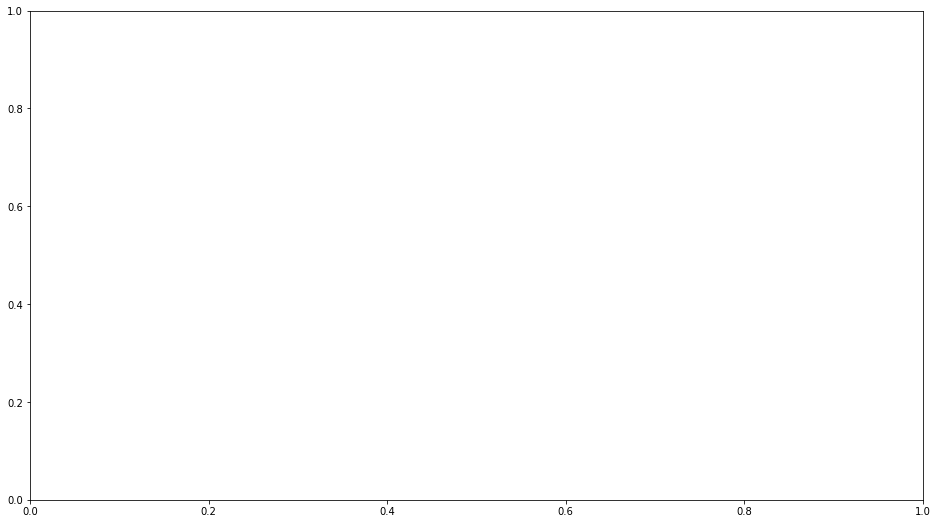

In [29]:
line_one = trip_lengths[trip_lengths['lineid'] == 1]
fig, ax = plt.subplots(figsize=(16,9))
line_one.plot(x='stops', y='scheduled', kind='bar', ax=ax)
line_one.plot(x='stops', y='observed', sharey=True, kind='bar', ax=ax)

### Trying to group arrival-departure times first
Assuming a maximum time for any given train to dwell at a station, we will test this procedure on lines 1-2 first.

In [ ]:
sql = ''' CREATE MATERIALIZED VIEW test_day_stop_arrival AS
                SELECT trainid, lineid, traindirection, stationid, station_char, 
                MIN(create_date + timint * interval '1 minute') AS expected_arrival, timint, train_message,
                
        FROM test_day
        WHERE (timint < 1 OR train_message = 'AtStation')
        GROUP BY trainid, lineid, traindirection, stationid, station_char,  '''